# [Lab 02 - Implementacja propagacji wstecznej błędu](http://pages.mini.pw.edu.pl/~karwowskij/mioad/lab-sieci.html#org5e8c9e3)

W ramach tego laboratorium trzeba zaimplementować **uczenie sieci neuronowej propagacją wsteczną błędu**.
Aby sprawdzić implementację, należy wykonać uczenie na prostych danych do uczenia dostarczonych na zajęciach.
Następnie należy zaimplementować **metodę wizualizacji wartości wag sieci** w kolejnych iteracjach i, w przypadku gdy nie udaje się nauczyć sieci, spróbować wykorzystać te wizualizacje do ustalenia przyczyny problemu.
Zaimplementować wersję z aktualizacją wag po prezentacji wszystkich wzorców i wersję z aktualizacją po prezentacji kolejnych porcji (batch).
Porównać szybkość uczenia dla każdego z wariantów.

Rozważyć trzy warianty inicjowania wag do procesu uczenia wagi z rozkładu jednostajnego na przedziale [0,1].
Opcjonalnie zaimplementować inną metodą inicjowania wag.
Albo metodę He albo Xavier.

Przetestować uczenie sieci na następujących zbiorach:
- square-simple (jeśli sieć nie jest w stanie się nauczyć tej funkcji to coś jest bardzo źle zrobione),
- steps-small,
- multimodal-large.

In [32]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import metrics

# visualization from https://github.com/jzliu-100/visualize-neural-network/blob/master/VisualizeNN.py
import visNN


## Model

In [2]:
class MLP:

    def __init__(self, layers, weights, biases, visualize_weights = False):
        self.layers = layers
        self.weights = weights
        self.biases = biases

        self.derivative_w = []
        self.derivative_b = []
        self.visualize_weights = visualize_weights


    def forward(self, inputs):
        """
        performs forward propagation
        """
        # activations and linear combinations passed to activation function
        self.activations = []
        self.z_values = []

        activations = inputs
        self.activations.append(activations)
        for i in range(len(self.layers)-2):

            outputs = activations @ self.weights[i] + self.biases[i]
            self.z_values.append(outputs)
            activations = self.sigmoid(outputs)
            self.activations.append(activations)
        activations.shape
        self.weights[-1].shape
        results = activations @ self.weights[-1] + self.biases[-1]
        self.z_values.append(results)
        self.activations.append(results)
        return results


    def backpropagation(self, y):
        deltas = [None] * len(self.weights)
        deltas[-1] = y - self.activations[-1]

        for i in reversed(range(len(deltas) - 1)):
            deltas[i] = ((self.weights[i + 1] @ deltas[i + 1].T ) * self.sigmoidGradient(self.z_values[i]).T).T

        m = y.shape[0]

        derivative_b = [None] * len(deltas)
        derivative_w = [None] * len(deltas)

        for i, d in enumerate(deltas):
            derivative_w[i] = (d.T @ self.activations[i]).T / m
            derivative_b[i] = (d.T @ np.ones((m, 1))).T / m

        return derivative_w, derivative_b

    def train(self, x, y, batch_size=20, epochs=500, alpha=0.1, verbose=False):

        p = np.random.permutation(len(y))
        x = x[p]
        y = y[p]


        for epoch in range(epochs):
            i = 0
            while i < len(y):
                x_batch = x[i:i + batch_size]
                y_batch = y[i:i + batch_size]
                i = i + batch_size
                self.forward(x_batch)
                derivative_w, derivative_b = self.backpropagation(y_batch)

                for j, weight in enumerate(self.weights):
                    self.weights[j] = weight + alpha * derivative_w[j]

                for j, bias in enumerate(self.biases):
                    self.biases[j] = bias + alpha * derivative_b[j]

            
            
            if self.visualize_weights:
                if epoch%100 == 0:
                    
                    print("Error in epoch {} = {}".format(epoch, np.linalg.norm(self.activations[-1] - y_batch)))
                    network_structure = np.asarray(layers)
                    network=visNN.DrawNN(network_structure, self.weights)
                    network.draw()
            else: 
                print("Error in epoch {} = {}".format(epoch, np.linalg.norm(self.activations[-1] - y_batch)), end = '\r')


    @staticmethod
    def sigmoid(x):
        return np.exp(x) / (1 + np.exp(x))

    @staticmethod
    def sigmoidGradient(x):
        def sigmoid(x):
            return np.exp(x) / (1 + np.exp(x))
        return sigmoid(x) * (1 - sigmoid(x))

In [3]:
def generate_weights_and_biases(layers, lower, upper):

    weights = []
    biases = []

    for i in range(len(layers) - 1):
        weights.append(np.random.uniform(lower, upper, layers[i] * layers[i + 1]).reshape(layers[i], layers[i + 1]))
        biases.append(np.random.uniform(lower, upper, layers[i + 1]).reshape(1, layers[i+1]))

    return weights, biases

# Testowanie modelu na danych
## Square simple

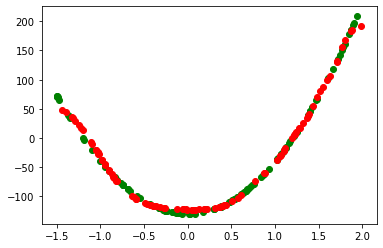

In [28]:
train_df = pd.read_csv('../data/square-simple-training.csv', index_col=0)
test_df = pd.read_csv('../data/square-simple-test.csv', index_col=0)

x = np.asarray(train_df['x']).reshape(-1, 1)
y = np.asarray(train_df['y']).reshape(-1, 1)
x_test = np.asarray(test_df['x']).reshape(-1,1)

layers=[1, 5, 1]
weights, biases = generate_weights_and_biases(layers, -1, 1)

mlp = MLP(
    layers, 
    weights,
    biases    
    #draw_weights=True  # sieć można narysować wykorzystując networkx, matplotlib lub inne biblioteki
)



mlp.train(x, y, epochs=100000, batch_size = 100, alpha=0.001)

predictions = mlp.forward(x_test)


plt.scatter(train_df['x'], train_df['y'], color='green')
plt.scatter(test_df['x'], predictions, color='red')
plt.show()

## multimodal-small

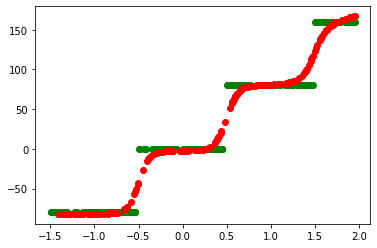

In [31]:
train_df = pd.read_csv('../data/multimodal-small-training.csv', index_col=0)
test_df = pd.read_csv('../data/multimodal-small-test.csv', index_col=0)

x = np.asarray(train_df['x']).reshape(-1, 1)
y = np.asarray(train_df['y']).reshape(-1, 1)
x_test = np.asarray(test_df['x']).reshape(-1,1)

layers=[1, 10, 1]
weights, biases = generate_weights_and_biases(layers, -1, 1)

mlp = MLP(
    layers, 
    weights,
    biases    
    #draw_weights=True  # sieć można narysować wykorzystując networkx, matplotlib lub inne biblioteki
)



mlp.train(x, y, epochs=1000, batch_size = 100, alpha=0.01)

predictions = mlp.forward(x_test)


plt.scatter(train_df['x'], train_df['y'], color='green')
plt.scatter(test_df['x'], predictions, color='red')
plt.show()

## multimodal-large

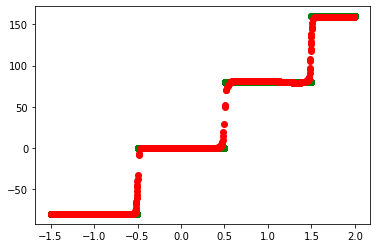

In [33]:
train_df = pd.read_csv('../data/multimodal-large-training.csv', index_col=0)
test_df = pd.read_csv('../data/multimodal-large-test.csv', index_col=0)

x = np.asarray(train_df['x']).reshape(-1, 1)
y = np.asarray(train_df['y']).reshape(-1, 1)
x_test = np.asarray(test_df['x']).reshape(-1,1)

layers=[1, 5, 5, 1]
weights, biases = generate_weights_and_biases(layers, -1, 1)

mlp = MLP(
    layers, 
    weights,
    biases    
    #draw_weights=True  # sieć można narysować wykorzystując networkx, matplotlib lub inne biblioteki
)



mlp.train(x, y, epochs=1000, batch_size = 100, alpha=0.001)

predictions = mlp.forward(x_test)


plt.scatter(train_df['x'], train_df['y'], color='green')
plt.scatter(test_df['x'], predictions, color='red')
plt.show()

# Szybkość i jakość trenowania a batch size 
Aby przeprowadzić ten eksperyment weźmy zbiór `multimodal-large`

### batch = 100

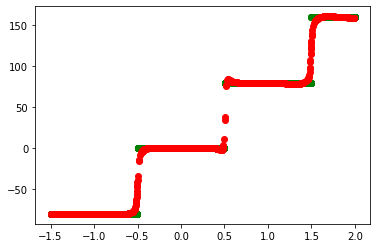

CPU times: user 12.5 s, sys: 46.3 ms, total: 12.5 s
Wall time: 12.4 s


In [45]:
%%time
train_df = pd.read_csv('../data/multimodal-large-training.csv', index_col=0)
test_df = pd.read_csv('../data/multimodal-large-test.csv', index_col=0)

x = np.asarray(train_df['x']).reshape(-1, 1)
y = np.asarray(train_df['y']).reshape(-1, 1)
x_test = np.asarray(test_df['x']).reshape(-1,1)

layers=[1, 5, 5, 1]
weights, biases = generate_weights_and_biases(layers, -1, 1)

mlp = MLP(
    layers, 
    weights,
    biases    
    #draw_weights=True  # sieć można narysować wykorzystując networkx, matplotlib lub inne biblioteki
)



mlp.train(x, y, epochs=1000, batch_size = 100, alpha=0.001)

predictions = mlp.forward(x_test)


plt.scatter(train_df['x'], train_df['y'], color='green')
plt.scatter(test_df['x'], predictions, color='red')
plt.show()

In [67]:
metrics.mean_absolute_error(test_df['y'], predictions)

1.4268533806139674

### batch = len(x)

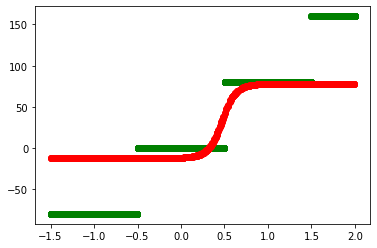

CPU times: user 39.6 s, sys: 594 ms, total: 40.2 s
Wall time: 6.75 s


In [68]:
%%time

weights, biases = generate_weights_and_biases(layers, -1, 1)

mlp = MLP(
    layers, 
    weights,
    biases
)


mlp.train(x, y, epochs=1000, batch_size = len(x), alpha=0.001)

predictions = mlp.forward(x_test)


plt.scatter(train_df['x'], train_df['y'], color='green')
plt.scatter(test_df['x'], predictions, color='red')
plt.show()

In [69]:
metrics.mean_absolute_error(test_df['y'], predictions)

35.86787743191555

Jak widać dla zadanych ilości `epoch` sieć nie zbiega do optymalnego rozwiązania dla danego batcha. Sprawdźmy co się stanie jak zwiększymy ilość `epoch` 10 razy

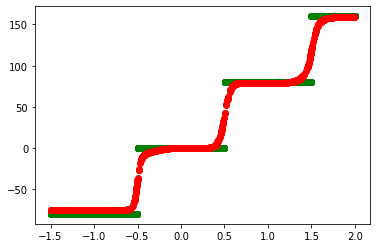

CPU times: user 5min 27s, sys: 5.72 s, total: 5min 33s
Wall time: 55.5 s


In [70]:
%%time

weights, biases = generate_weights_and_biases(layers, -1, 1)

mlp = MLP(
    layers, 
    weights,
    biases    
)


mlp.train(x, y, epochs=10000, batch_size = len(x), alpha=0.001)

predictions = mlp.forward(x_test)


plt.scatter(train_df['x'], train_df['y'], color='green')
plt.scatter(test_df['x'], predictions, color='red')
plt.show()

In [71]:
metrics.mean_absolute_error(test_df['y'], predictions)

5.107965293703166

Po jednej minucie otrzymaliśmy sieć, która lepiej aproksymuje daną funkcję. Metryka błędu jest jednak większa niż dla `batch = 100`. Czas z kolei jest prawie 10 krotnie większy. Wnioskuję z tego, że algorytm szybciej zbiega gdy zamiast uaktualniać wagi po całym przejściu zbioru danych, należy to zrobić po jakimś mniejszym jego wycinku.

# Inicjalizacja wag
W tym eksperymencie przetestujemy 3 sposoby inicjalizacji wag na przedziale jednostajnych `[-1,1]`, `[0,1]` oraz za pomocą metody [Xavier](https://cs230.stanford.edu/section/4/). Wytrenujemy po 100 sieci, które będą się różnić jedynie metodami inicjalizacji wag. Sieci będą miały za mało iteracji, żeby w pełni zbiec do minimum. Dzięki temu będziemy wiedzieć, która metoda daje nam największą przewagę. Nasze dane będą w pełni znormalizowane. 

In [30]:
train_df = pd.read_csv('../data/square-simple-training.csv', index_col=0)
test_df = pd.read_csv('../data/square-simple-test.csv', index_col=0)

x = np.asarray(train_df['x']).reshape(-1, 1) 
x = (x - np.mean(x))/np.std(x)

y = np.asarray(train_df['y']).reshape(-1, 1) 
y = (y - np.mean(y))/np.std(y)

x_test = np.asarray(test_df['x']).reshape(-1,1)
x_test = (x_test - np.mean(x_test))/np.std(x_test)

layers=[1, 5, 1]


results1 = []
for i in range (100):
    
    weights, biases = generate_weights_and_biases(layers, -1, 1)

    mlp = MLP(layers, weights, biases)
    mlp.train(x, y, epochs=100, batch_size = 100, alpha=0.1)
    
    predictions = mlp.forward(x_test)

    results1.append(metrics.mean_absolute_error(x_test, predictions))


results2 = []
for i in range (100):
    
    weights, biases = generate_weights_and_biases(layers, 0, 1)

    mlp = MLP(layers, weights, biases)
    mlp.train(x, y, epochs=100, batch_size = 100, alpha=0.1)

    predictions = mlp.forward(x_test)

    results2.append(metrics.mean_absolute_error(x_test, predictions))

results3 = []
for i in range (100):
    
    biases = [np.zeros(5).reshape(1, -1), np.zeros(1).reshape(1, -1)]
    weights = [np.random.normal(0, 1/5, 5).reshape(1,-1), np.random.normal(0, 1/5, 5).reshape(-1,1)]
    
    mlp = MLP(layers, weights, biases)
    mlp.train(x, y, epochs=100, batch_size = 100, alpha=0.1)

    predictions = mlp.forward(x_test)

    results3.append(metrics.mean_absolute_error(x_test, predictions))

    

In [31]:
print(f'Initialization [-1,1]: \t{np.mean(results1)}\nInitialization [0,1]: \t{np.mean(results2)}\nInitialization Xavier: \t{np.mean(results3)} ')

Initialization [-1,1]: 	0.5602580472533156
Initialization [0,1]: 	0.6779488668906055
Initialization Xavier: 	0.7731942177693422 


Po stworzeniu wielu modeli najlepszą inicjalizacją wag okazało się `[-1,1]` a najgorszą `Xavier` 

# Wizualizacja wag

Error in epoch 0 = 13.570321984032384


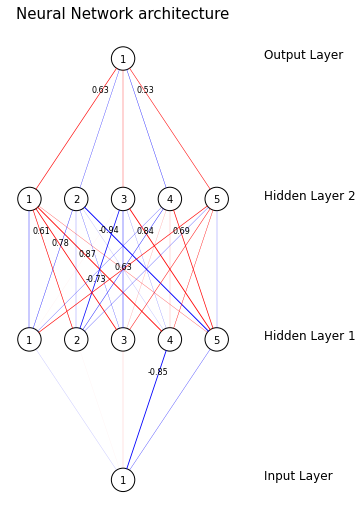

Error in epoch 100 = 9.636156303120151


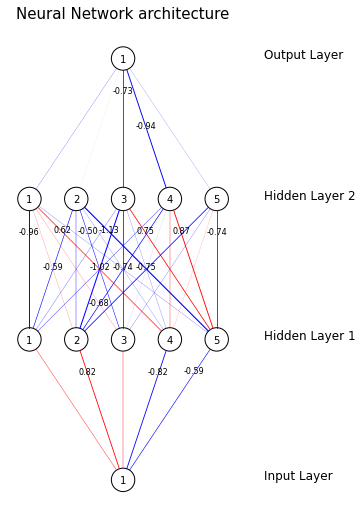

Error in epoch 200 = 5.314148551620271


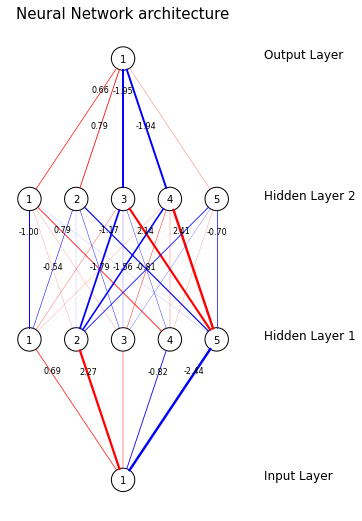

Error in epoch 300 = 2.57395496781259


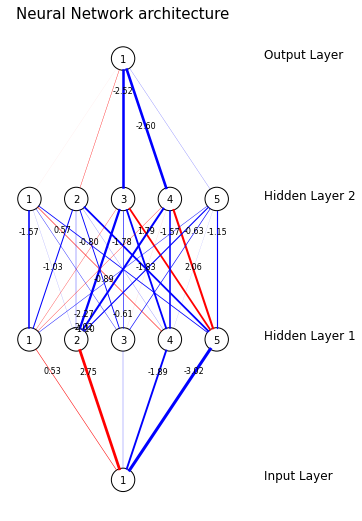

Error in epoch 400 = 8.762988948434728


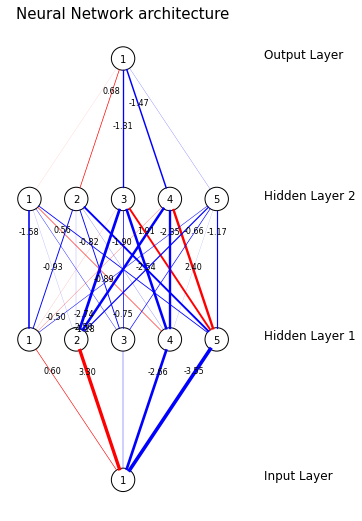

Error in epoch 500 = 5.616543233156126


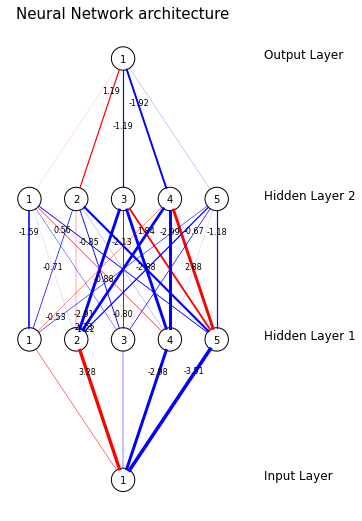

Error in epoch 600 = 3.7454351018403593


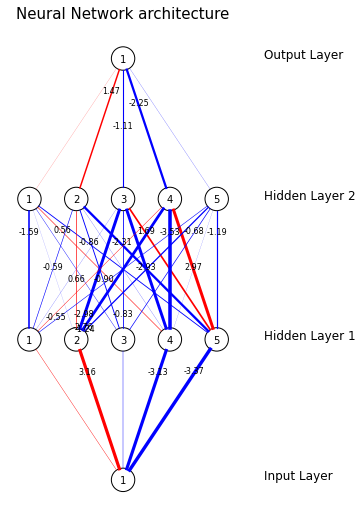

Error in epoch 700 = 3.0493901472748446


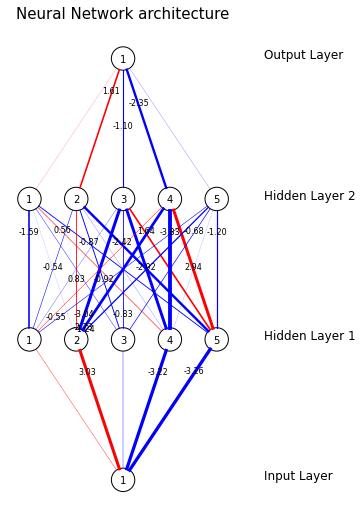

Error in epoch 800 = 2.7342875345452273


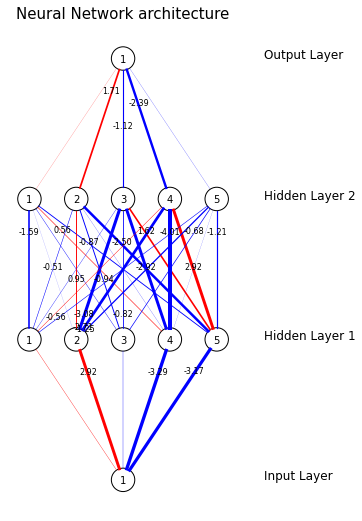

Error in epoch 900 = 2.53720093053455


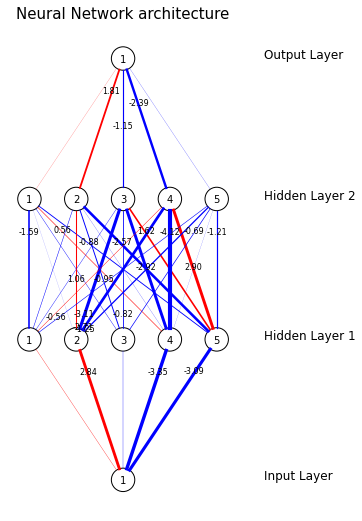

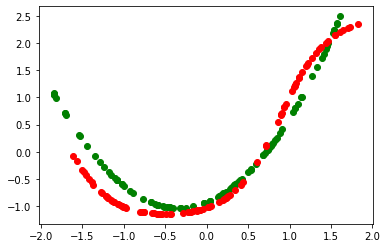

In [4]:
train_df = pd.read_csv('../data/square-simple-training.csv', index_col=0)
test_df = pd.read_csv('../data/square-simple-test.csv', index_col=0)

# must normalize (because of the width of weights)
x = np.asarray(train_df['x']).reshape(-1, 1) 
x = (x - np.mean(x))/np.std(x)
y = np.asarray(train_df['y']).reshape(-1, 1) 
y = (y - np.mean(y))/np.std(y)
x_test = np.asarray(test_df['x']).reshape(-1,1)

layers=[1, 5,5, 1]
weights, biases = generate_weights_and_biases(layers, -1, 1)

mlp = MLP(
    layers, 
    weights,
    biases,    
    visualize_weights = True
)

mlp.train(x, y, epochs=1000, batch_size = 100, alpha=1)

predictions = mlp.forward(x_test)

x_test = test_df['x']
x_test = (x_test - np.mean(x_test))/np.std(x_test)


plt.scatter(x, y, color='green')
plt.scatter(x_test, predictions, color='red')
plt.show()

Jak widać sieć dobrze dopasowuje się do zbioru danych. Wagi losowane są z przedziału [-1, 1] i początkowo, widać, że są rozłożone w miarę równomiernie. Po kilkuset `epochs` następuje większa 'aktywacja' niektórych neuronów a co za tym idzie zwiększenie się wartości absolutnej niektórych wag. 